In this Notebook we will
- Load a national model
- Load national hospitalisation data
- Define a range of warmup values
- Define a range of infectivity values
- Plot the log likelihood function in function of the warmup and infectivity values in a heat plot
- Clearly demonstrate the correlation between warmup and infectivity

# Preamble

In [5]:
import ujson as json
import random
import emcee
import datetime
import corner
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import multiprocessing as mp
from multiprocessing import Pool
from covid19model.models import models
from covid19model.optimization.objective_fcns import prior_custom, prior_uniform
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.optimization import pso, objective_fcns
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
from covid19model.visualization.optimization import autocorrelation_plot, traceplot

# Load data & time-dependent parameter function

In [6]:
# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
# Sciensano data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)

# Initialise model

In [7]:
# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters()
# Define initial states
initial_states = {"S": initN, "E": np.ones(9)}
# Initialize model
model = models.COVID19_SEIRD(initial_states, params)

# Start of data collection
start_date = '2020-03-15'
# Last datapoint used to calculate loglikelihood
end_date = '2020-03-21'

# Show one example

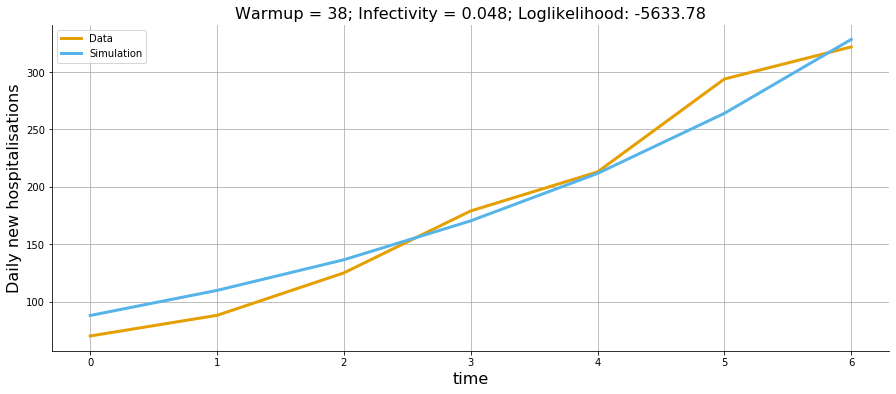

In [8]:
ydata = df_sciensano['H_in'][start_date:end_date].values

warmup=38
infectivity=0.048
params.update({'beta':infectivity})
model = models.COVID19_SEIRD(initial_states, params)

out = model.sim(end_date, warmup=warmup, start_date=start_date)
ymodel = out['H_in'].sum(dim='Nc').values[-len(ydata):]
ymodel

poisson_offset=1
ll = -objective_fcns.ll_poisson(ymodel, ydata, offset=poisson_offset)

fig, ax = plt.subplots(figsize=(15, 6))
xtime=np.arange(len(ydata))
fontsize=16
ax.plot(xtime, ydata, label='Data')
ax.plot(xtime, ymodel, label='Simulation')
ax.set_xlabel("time", fontsize=fontsize)
ax.set_ylabel("Daily new hospitalisations", fontsize=fontsize)
ax.legend()
title=ax.set_title(f"Warmup = {warmup}; Infectivity = {round(infectivity, 3)}; Loglikelihood: {round(ll,2)}", fontsize=fontsize)

# Calculate loglikelihood for macroscopic range

In [11]:
# Initialise new loglikelihood matrix

warmup_range = np.array(list(range(20, 101)))
infectivity_range = np.linspace(0.02, 0.08, 101)

# ll = np.empty([len(warmup_range), len(infectivity_range)])

In [12]:
# Loop over entire range

for w_idx, warmup in enumerate(warmup_range):
    print(f'warmup = {warmup} ... ', end='\r')
    for i_idx, infectivity in enumerate(infectivity_range):
        # Initialise model
        params.update({'beta':infectivity})
        model = models.COVID19_SEIRD(initial_states, params)
        # Calculate simulation
        out = model.sim(end_date, warmup=warmup, start_date=start_date)
        ymodel = out['H_in'].sum(dim='Nc').values[-len(ydata):]
        # Calculate loglikelihood
        ll_new = -objective_fcns.ll_poisson(ymodel, ydata, offset=poisson_offset)
        ll[w_idx, i_idx] = ll_new

print(f"Finished calculating {ll.size} loglikelihood values.")
ll_matrix = ll.copy()

Finished calculating 8181 loglikelihood values.


# Visualise the macroscopic result

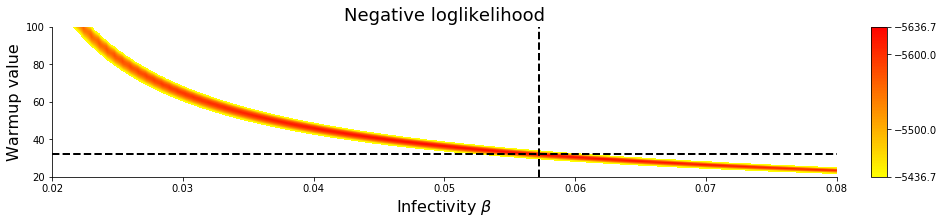

In [114]:
fig, ax = plt.subplots(figsize=(13, 3),constrained_layout=True)
width=200

cmap = plt.cm.get_cmap("autumn")
levels = np.linspace(np.min(ll_matrix),np.min(ll_matrix)+width,100)
cf = ax.contourf(infectivity_range, warmup_range, ll_matrix, 100, levels=levels, cmap=cmap)
ax.grid(False)
ax.set_xlabel(r'Infectivity $\beta$', fontsize=fontsize)
ax.set_ylabel(r'Warmup value', fontsize=fontsize)
ax.set_title(r'Negative loglikelihood', fontsize=fontsize+2)
cb1 = fig.colorbar(cf, ax=ax, aspect=40, ticks=[levels[0], -5500, -5600, levels[-1]])
cb1.ax.invert_yaxis()

# Indicate extremum
(xloc_min, yloc_min) = np.unravel_index(np.argmin(ll_matrix), ll_matrix.shape)
ax.axvline(infectivity_range[yloc_min], color='k', linestyle='--', linewidth=2)
ax.axhline(warmup_range[xloc_min], color='k', linestyle='--', linewidth=2)

# savename="relation"
# plt.savefig

# Calculate loglikelihood for microscopic range

In [111]:
# Initialise new loglikelihood matrix

warmup_range_micro = np.linspace(29, 36, 15)# np.array(list(range(29, 36)))
infectivity_range_micro = np.linspace(0.0500, 0.0625, 201)

ll_micro = np.empty([len(warmup_range_micro), len(infectivity_range_micro)])

In [112]:
# Loop over entire range

for w_idx, warmup in enumerate(warmup_range_micro):
    print(f'warmup = {warmup} ... ', end='\r')
    for i_idx, infectivity in enumerate(infectivity_range_micro):
        # Initialise model
        params.update({'beta':infectivity})
        model = models.COVID19_SEIRD(initial_states, params)
        # Calculate simulation
        out = model.sim(end_date, warmup=warmup, start_date=start_date)
        ymodel = out['H_in'].sum(dim='Nc').values[-len(ydata):]
        # Calculate loglikelihood
        ll_new = -objective_fcns.ll_poisson(ymodel, ydata, offset=poisson_offset)
        ll_micro[w_idx, i_idx] = ll_new

print(f"Finished calculating {ll_micro.size} loglikelihood values.")
ll_matrix_micro = ll_micro.copy()

Finished calculating 3015 loglikelihood values.


# Visualise the microscopic result

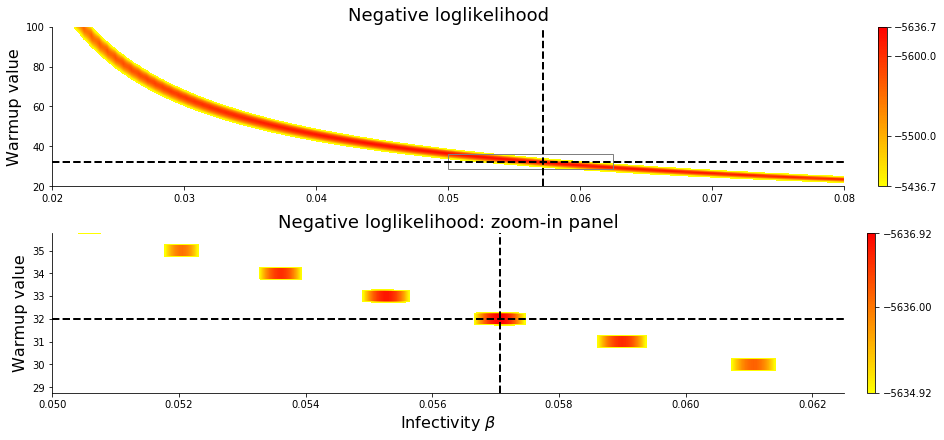

In [123]:
fig2, (ax, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(13, 6),constrained_layout=True)
width_micro=2

cmap = plt.cm.get_cmap("autumn")
levels = np.linspace(np.min(ll_matrix),np.min(ll_matrix)+width,100)
cf = ax.contourf(infectivity_range, warmup_range, ll_matrix, 100, levels=levels, cmap=cmap)
ax.grid(False)
# ax.set_xlabel(r'Infectivity $\beta$', fontsize=fontsize)
ax.set_ylabel(r'Warmup value', fontsize=fontsize)
ax.set_title(r'Negative loglikelihood', fontsize=fontsize+2)
cb1 = fig.colorbar(cf, ax=ax, aspect=40, ticks=[levels[0], -5500, -5600, levels[-1]])
cb1.ax.invert_yaxis()

# Indicate extremum
(xloc_min, yloc_min) = np.unravel_index(np.argmin(ll_matrix), ll_matrix.shape)
ax.axvline(infectivity_range[yloc_min], color='k', linestyle='--', linewidth=2)
ax.axhline(warmup_range[xloc_min], color='k', linestyle='--', linewidth=2)

# Zoom-in
cmap2 = plt.cm.get_cmap("autumn")
levels_micro = np.linspace(np.min(ll_matrix_micro),np.min(ll_matrix_micro)+width_micro,100)
cf2 = ax2.contourf(infectivity_range_micro, warmup_range_micro-0.25, ll_matrix_micro, 100, \
                   levels=levels_micro, cmap=cmap2, )
ax2.grid(False)
ax2.set_xlabel(r'Infectivity $\beta$', fontsize=fontsize)
ax2.set_ylabel(r'Warmup value', fontsize=fontsize)
ax2.set_title(r'Negative loglikelihood: zoom-in panel', fontsize=fontsize+2)
cb2 = fig2.colorbar(cf2, ax=ax2, aspect=40, ticks=[levels_micro[0], -5636, levels_micro[-1]])
cb2.ax.invert_yaxis()

# Indicate extremum
(xloc_min, yloc_min) = np.unravel_index(np.argmin(ll_matrix_micro), ll_matrix_micro.shape)
ax2.axvline(infectivity_range_micro[yloc_min], color='k', linestyle='--', linewidth=2)
ax2.axhline(warmup_range_micro[xloc_min], color='k', linestyle='--', linewidth=2)

# Draw box around
from matplotlib.patches import Rectangle
ax.add_patch(Rectangle((0.05, 28.75), 0.0125, 7.5,
                        edgecolor = 'grey',
                        fill=False))

savename = "loglikelihood_correlation-warmup-infectivity.png"
plt.savefig(savename, dpi=400, bbox_inches='tight')